# Session 4 — Paragraph-Level Analysis
## Measure 5: Paragraph Function Classification

In this notebook, you will:
- define a small set of **paragraph function labels**
  (dialogue, action, description, internal_monologue, other)
- create short **prototype texts** for each label
- embed both prototypes and real paragraphs with MiniLM
- assign to each paragraph the label whose prototype is most similar.

This mimics how agentic LLM systems classify chunks of text into roles
(instruction, context, plan, reflection, etc.).


In [1]:
import re
from typing import List, Dict
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

# You may need to install this once in your environment:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

def load_book(filepath: str) -> str:
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    if 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]

    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]

    return text.strip()

pride_text = load_book('../data/pride.txt')
sense_text = load_book('../data/sense.txt')

print(f"Pride characters: {len(pride_text):,}")
print(f"Sense characters: {len(sense_text):,}")


Pride characters: 689,703
Sense characters: 670,596


In [2]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    raw_paras = re.split(r'\n\s*\n+', text)
    paras = []
    for p in raw_paras:
        cleaned = re.sub(r'\s+', ' ', p).strip()
        if not cleaned:
            continue
        if len(cleaned.split()) < min_words:
            continue
        paras.append(cleaned)
    return paras

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    if a.ndim > 1:
        a = a.reshape(-1)
    if b.ndim > 1:
        b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)

# Define prototype texts for each label.
# You can edit these to better fit your author's style.
PROTOTYPES: Dict[str, List[str]] = {
    'dialogue': [
        '"What are you doing here?" she asked quietly.',
        '"I cannot explain it," he replied, "but I must try."',
    ],
    'action': [
        'She ran down the hallway and opened the heavy door.',
        'He turned quickly, jumped over the fence, and disappeared into the forest.',
    ],
    'description': [
        'The room was small and dimly lit, with dusty books lining the wooden shelves.',
        'A cold wind moved softly through the tall, dark trees of the silent garden.',
    ],
    'internal_monologue': [
        'I wondered whether I had made a terrible mistake and what would happen next.',
        'In my mind I repeated the same question again and again, unable to decide.',
    ],
    'other': [
        'The narrator provides context and explanation that does not fit clearly into the other categories.',
    ],
}

def build_prototype_embeddings() -> Dict[str, np.ndarray]:
    proto_embs = {}
    for label, examples in PROTOTYPES.items():
        embs = model.encode(examples)
        proto_embs[label] = embs.mean(axis=0)
    return proto_embs

prototype_embeddings = build_prototype_embeddings()

def classify_paragraph_embedding(paragraph: str, proto_embs: Dict[str, np.ndarray]) -> str:
    """Assign the label whose prototype embedding is most similar."""
    emb = model.encode(paragraph)
    best_label = None
    best_sim = -1.0
    for label, proto in proto_embs.items():
        sim = cosine_similarity(emb, proto)
        if sim > best_sim:
            best_sim = sim
            best_label = label
    return best_label or 'other'

def classify_all(paragraphs: List[str], proto_embs: Dict[str, np.ndarray]) -> List[str]:
    labels = []
    for p in paragraphs:
        if len(p.split()) < 5:
            continue
        labels.append(classify_paragraph_embedding(p, proto_embs))
    return labels

pride_paras = split_into_paragraphs(pride_text)
sense_paras = split_into_paragraphs(sense_text)

p_labels = classify_all(pride_paras, prototype_embeddings)
s_labels = classify_all(sense_paras, prototype_embeddings)

def label_counts(labels: List[str]) -> Counter:
    c = Counter(labels)
    total = sum(c.values()) or 1
    for k, v in c.items():
        print(f"{k:18s}: {v:4d} ({v/total*100:5.1f}%)")
    return c

print("Pride paragraph types (embedding-based):")
p_counts = label_counts(p_labels)

print("\nSense paragraph types (embedding-based):")
s_counts = label_counts(s_labels)


Pride paragraph types (embedding-based):
other             :  244 ( 13.3%)
dialogue          : 1162 ( 63.3%)
action            :  175 (  9.5%)
description       :  196 ( 10.7%)
internal_monologue:   60 (  3.3%)

Sense paragraph types (embedding-based):
other             :  274 ( 16.9%)
description       :  141 (  8.7%)
action            :  120 (  7.4%)
internal_monologue:   81 (  5.0%)
dialogue          : 1002 ( 61.9%)


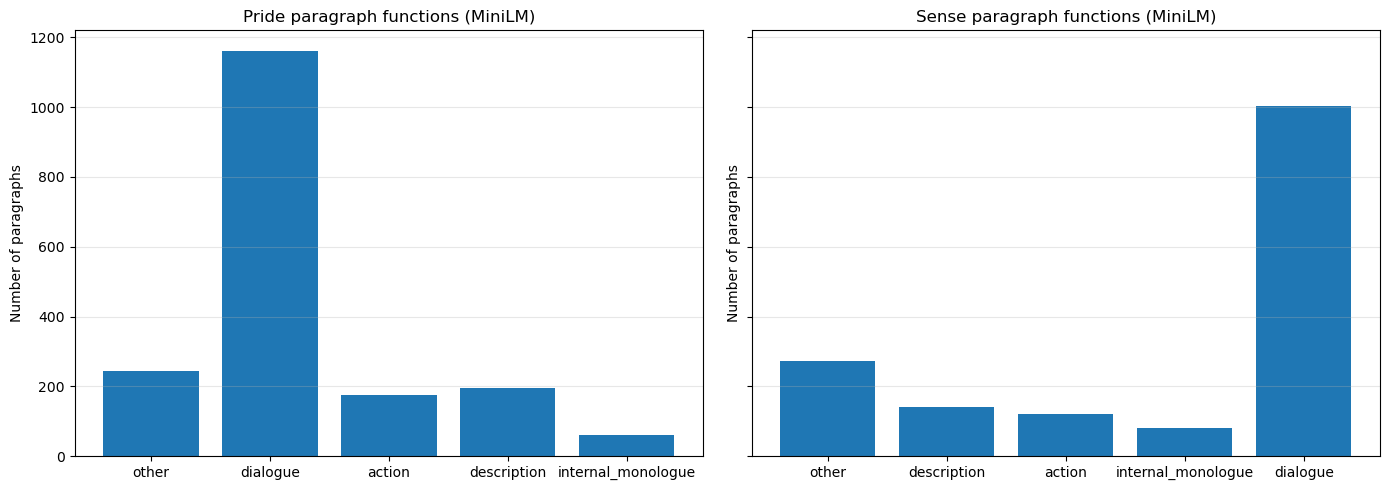

In [3]:
def plot_label_bars(counts: Counter, title: str, ax):
    labels = list(counts.keys())
    values = [counts[k] for k in labels]
    ax.bar(labels, values)
    ax.set_title(title)
    ax.set_ylabel('Number of paragraphs')
    ax.grid(True, axis='y', alpha=0.3)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

plot_label_bars(p_counts, 'Pride paragraph functions (MiniLM)', axes[0])
plot_label_bars(s_counts, 'Sense paragraph functions (MiniLM)', axes[1])

plt.tight_layout()
plt.show()


In [4]:
def show_examples(paragraphs: List[str], labels: List[str], target_label: str, n: int = 3):
    print(f"\n=== Examples for label: {target_label} ===")
    count = 0
    for p, lab in zip(paragraphs, labels):
        if lab == target_label:
            print('\n---')
            snippet = p.strip()
            if len(snippet) > 500:
                snippet = snippet[:500] + '...'
            print(snippet)
            count += 1
            if count >= n:
                break

show_examples(pride_paras, p_labels, 'dialogue')
show_examples(pride_paras, p_labels, 'action')
show_examples(pride_paras, p_labels, 'internal_monologue')



=== Examples for label: dialogue ===

---
“We are not in a way to know _what_ Mr. Bingley likes,” said her mother, resentfully, “since we are not to visit.”

---
“But you forget, mamma,” said Elizabeth, “that we shall meet him at the assemblies, and that Mrs. Long has promised to introduce him.”

---
“I do not believe Mrs. Long will do any such thing. She has two nieces of her own. She is a selfish, hypocritical woman, and I have no opinion of her.”

=== Examples for label: action ===

---
“Ay, so it is,” cried her mother, “and Mrs. Long does not come back till the day before; so, it will be impossible for her to introduce him, for she will not know him herself.”

---
Mr. Bingley followed his advice. Mr. Darcy walked off; and Elizabeth remained with no very cordial feelings towards him. She told the story, however, with great spirit among her friends; for she had a lively, playful disposition, which delighted in anything ridiculous.

---
“It will be _her_ turn soon to be teased,” said

## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [5]:
import gc

# Delete large variables to free memory
del pride_text, sense_text
del pride_paras, sense_paras
del p_labels, s_labels, p_counts, s_counts
del prototype_embeddings

# Clear matplotlib figures
plt.close('all')

# Unload the model from memory
del model

# Force garbage collection
gc.collect()

print("Memory cleaned! Large variables deleted and garbage collected.")

Memory cleaned! Large variables deleted and garbage collected.
